In [30]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [31]:
from plot_config import *

In [32]:
from utils import *

In [33]:
xg = np.load('plotting_xg.npy')
yg = np.load('plotting_yg.npy')

In [34]:
mmp,mtb = open_case_month('salty',1)
to_mesh = -mmp['F'][0]
to_contour = mmp['count'][0]
for j in range(2,4):
    mmp,mtb = open_case_month('salty',j)
    to_mesh-=mmp['F'][0]
    to_contour==mmp['count'][0]

In [ ]:
# mp,tb = open_case('salty')


# ax = plt.axes(projection = ccrs.PlateCarree())
# plt.plot(tb.lon[90,::10000],tb.lat[90,::10000],'+')
# ax.coastlines()
# plt.xlim(-100,10)

# mvmax = 20
# mmp,mtb = open_case_month('salty',0)
# to_mesh = -mmp['F'][0]
# print(to_mesh.sum().values)
# ax = plt.axes(projection = ccrs.PlateCarree())
# for fc in [2,6,10]:
#     ct = ax.pcolormesh(xg[fc],yg[fc],to_mesh[fc],vmax = mvmax, vmin = -mvmax,cmap = 'bwr')
# ax.coastlines()

# xrange = (-46.875,-30.625)
# yrange = (44.375,53.125)
# poly = poly_from_xyrange(xrange,yrange)
# nside = 6
# xs,ys = poly.T
# xs = list(xs)+[xs[0]]
# ys = list(ys)+[ys[0]]
# for i in range(len(poly)):
#     lx = np.linspace(xs[i],xs[i+1], nside)
#     ly = np.linspace(ys[i],ys[i+1], nside)
#     # print('how')
#     ax.plot(lx,ly,transform = ccrs.PlateCarree(),c = 'gold')
# plt.xlim(-100,10)

In [36]:
ecco = xr.open_zarr('/sciserver/oceanography/ECCO_v4r4/ecco_v4r4')

In [37]:
xc,yc = np.array(ecco.XC), np.array(ecco.YC)

In [38]:
im = 12*(2006-1992)+4

ecco.time[im].values,im

(numpy.datetime64('2006-05-16T12:00:00.000000000'), 172)

In [39]:
def mesh_contour(to_mesh, to_contour, 
                 mvmax = 1e2,
                 mesh_cmap = balance,
                 cvmax = 200,
                 clevels = 7,
                 ccolor = 'grey',
                 cont_cmap = cmocean.cm.deep,
                 level_type = 'negative',
                 colorbar_label = r'$PSU\cdot m$'
                ):
    plt.figure(figsize = (16,9))
    ax = plt.axes(projection = projection)
    extent = (-95, 15, 30, 65)
    ax.set_extent(extent)
    n = 20
    aoi = mpath.Path(
        list(zip(np.linspace(extent[0],extent[1], n), np.full(n, extent[3]))) + \
        list(zip(np.full(n, extent[1]), np.linspace(extent[3], extent[2], n))) + \
        list(zip(np.linspace(extent[1], extent[0], n), np.full(n, extent[2]))) + \
        list(zip(np.full(n, extent[0]), np.linspace(extent[2], extent[3], n)))
    )
    ax.set_boundary(aoi, transform=ccrs.PlateCarree())
    if level_type == 'negative':
        levels = np.linspace(-cvmax, 0,clevels)
    elif level_type == 'positive':
        levels = np.linspace(0,cvmax,clevels)
    else:
        levels = np.linspace(-cvmax, cvmax,clevels)

    for fc in [2,6,10]:
        ct = ax.pcolormesh(xg[fc],yg[fc],to_mesh[fc],vmax = mvmax, vmin = -mvmax,cmap = mesh_cmap,transform = ccrs.PlateCarree())
    ax.tricontour(xc.ravel(),
                  yc.ravel(),
                  to_contour.ravel(),
                  levels = levels,
                  # cmap = cont_cmap,
                  colors = ccolor,
                  transform = ccrs.PlateCarree())
    
    ax.add_feature(cfeature.LAND, zorder=10, facecolor='grey')
    plt.colorbar(ct,location = 'bottom',pad = 0.25,label = colorbar_label,aspect = 50,extend = 'both')
    return ax

In [40]:
rho0 = 1029
pe = ecco['oceFWflx']/1029*86400*1000

In [41]:
pe_mean = pe.mean(dim = 'time').persist()
pe_seas = pe.groupby('time.month').mean(dim ='time').persist()

In [42]:
pe_anom = pe.groupby('time.month') - pe_seas

/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


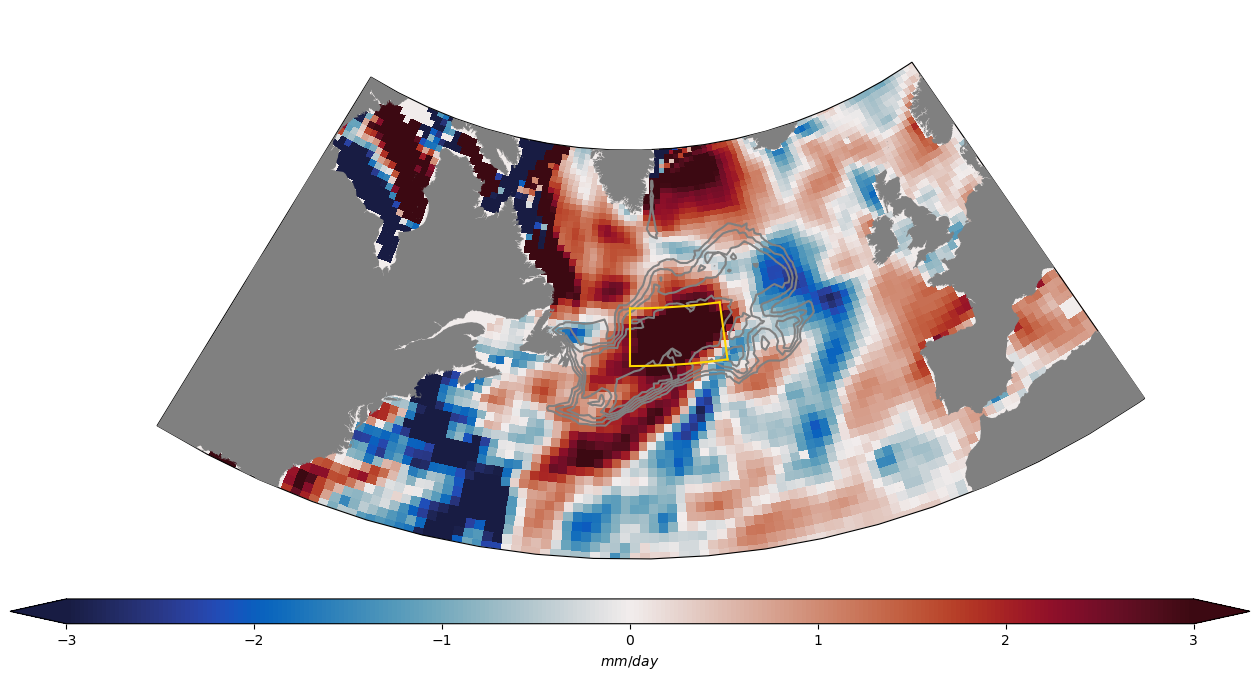

In [43]:
to_mesh = -pe_anom[im:im+2].sum(dim = 'time')
to_contour = np.array(to_contour)

ax = mesh_contour(to_mesh, to_contour,mvmax = 3,
                  level_type = 'positive',cvmax = 30000,clevels = 9,
                  colorbar_label = r'$mm/day$')

xrange = (-45,-32.5)
yrange = (47,52)
poly = poly_from_xyrange(xrange,yrange)
nside = 6
xs,ys = poly.T
xs = list(xs)+[xs[0]]
ys = list(ys)+[ys[0]]
for i in range(len(poly)):
    lx = np.linspace(xs[i],xs[i+1], nside)
    ly = np.linspace(ys[i],ys[i+1], nside)
    # print('how')
    ax.plot(lx,ly,transform = ccrs.PlateCarree(),c = 'gold')
plt.xlim(-100,10)
plt.savefig('figure6(a).png',dpi = dpi)

In [44]:
# mvmax = 5
# ax = plt.axes(projection = ccrs.PlateCarree())
# for fc in [2,6,10]:
#     ct = ax.pcolormesh(xg[fc],yg[fc],-pe_anom[im:im+2].sum(dim = 'time')[fc],vmax = mvmax, vmin = -mvmax,cmap = 'bwr')
# ax.coastlines()
# plt.xlim(-100,10)

In [45]:
those = np.where(
    np.logical_and(
        np.logical_and(xrange[0]<=xc,xrange[1]>xc),
        np.logical_and(yrange[0]<=yc,yrange[1]>yc)
    )
)

In [46]:
sfc,siy,six = [xr.DataArray(i, dims = 'to_sum') for i in those]

In [47]:
actual_area = float(ecco.rA[sfc,siy,six].sum())

In [48]:
pe_ts = (pe*ecco.rA/actual_area)[:,sfc,siy,six].sum(dim = 'to_sum').persist()
pe_seas_ts = (pe_seas*ecco.rA/actual_area)[:,sfc,siy,six].sum(dim = 'to_sum').persist()
pe_anom_ts = (pe_anom*ecco.rA/actual_area)[:,sfc,siy,six].sum(dim = 'to_sum').persist()

In [49]:
# sst_ts = ecco['THETA'][:,0,sfc,siy,six].sum(dim = 'to_sum').persist()
# sst_mean = sst_ts.mean(dim = 'time').persist()
# sst_seas = sst_ts.groupby('time.month').mean(dim ='time').persist()

In [50]:
# plt.plot(pe_ts[im-12:im+12])

In [51]:
path = '/export/scratch/wjiang33/jra55/'
evaps = sorted([i for i in os.listdir(path) if 'evp' in i])[3:]

evap_ds = [xr.open_dataset(path+file, engine = 'cfgrib') for file in evaps if 'idx' not in file]

evap = xr.concat(evap_ds,dim = 'time')

evap

precs = sorted([i for i in os.listdir(path) if 'tprat' in i])[3:]

prec_ds = [xr.open_dataset(path+file, engine = 'cfgrib') for file in precs if 'idx' not in file]

prec = xr.concat(prec_ds,dim = 'time')

jra = xr.merge([evap,prec])

In [52]:
def to_180(x, peri=360):
    """Convert any longitude scale to [-180,180)."""
    x = x % peri % peri
    # underflow resistant
    return x + (-1) * (x // (peri / 2)) * peri
ixs = xr.DataArray(np.where(np.logical_and(xrange[0]<=to_180(jra.longitude),xrange[1]>to_180(jra.longitude)))[0],dims = 'ix')
iys = xr.DataArray(np.where(np.logical_and(xrange[0]<=jra.latitude,xrange[1]>jra.latitude))[0],dims = 'iy')

cos = np.cos(jra.latitude[iys]*np.pi/180)

total = np.sum(cos)*len(ixs)

In [53]:
prec_ts = (jra.tpratsfc[:,iys,ixs]*cos).sum(dim = ('iy','ix'))/total
evap_ts = (jra.evpsfc[:,iys,ixs]  *cos).sum(dim = ('iy','ix'))/total

In [54]:
prec_seas_ts = prec_ts.groupby('time.month').mean(dim = 'time')
evap_seas_ts = evap_ts.groupby('time.month').mean(dim = 'time')
prec_seas_std = prec_ts.groupby('time.month').std(dim = 'time')
evap_seas_std = evap_ts.groupby('time.month').std(dim = 'time')

pe_seas_ts  = (prec_ts - evap_ts).groupby('time.month').mean(dim = 'time')
pe_seas_std = (prec_ts - evap_ts).groupby('time.month').std(dim = 'time')

In [55]:
# evap_mean = np.roll(np.array(evap_seas_ts), -month)
# evap_mean.shape

In [56]:
jra_time = jra.time[im-12:im+12]
ecco_time = ecco.time[im-12:im+12]
time = ecco_time
month = im%12
prec_mean = np.roll(np.array(prec_seas_ts), -month)
prec_mean = np.concatenate ([prec_mean,prec_mean])
prec_std =  np.roll(np.array(prec_seas_std), -month)
prec_std =  np.concatenate ([prec_std,prec_std])

evap_mean = np.roll(np.array(evap_seas_ts), -month)
evap_mean = np.concatenate ([evap_mean,evap_mean])
evap_std =  np.roll(np.array(evap_seas_std), -month)
evap_std =  np.concatenate ([evap_std,evap_std])

pe_mean = np.roll(np.array(pe_seas_ts), -month)
pe_mean = np.concatenate ([pe_mean,pe_mean])
pe_std =  np.roll(np.array(pe_seas_std), -month)
pe_std =  np.concatenate ([pe_std,pe_std])

In [57]:
prec_c = 'cadetblue'
evap_c = 'brown'
pe_c = 'darkblue'

mean_ls = ':'

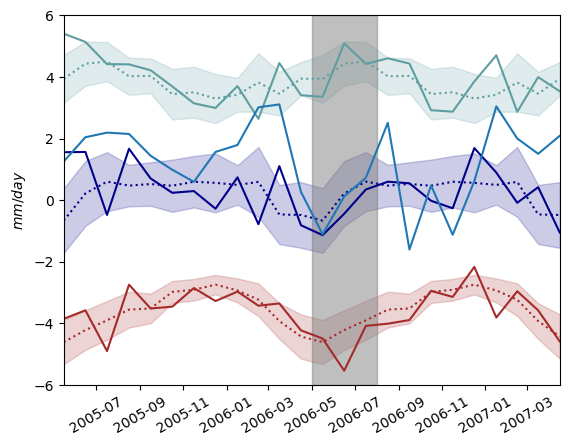

In [58]:
plt.plot(time,prec_mean,ls = mean_ls,c = prec_c)
plt.plot(time,prec_ts[im-12:im+12],c = prec_c)
plt.fill_between(time,prec_mean-prec_std,prec_mean+prec_std,alpha = 0.2,color = prec_c)

plt.plot(time,-evap_mean,ls = mean_ls,c = evap_c)
plt.plot(time,-evap_ts[im-12:im+12],c = evap_c)
plt.fill_between(time,-evap_mean-evap_std,-evap_mean+evap_std,alpha = 0.2,color = evap_c)

plt.plot(time,pe_mean,ls = mean_ls,c = pe_c)
plt.plot(time,prec_ts[im-12:im+12]-evap_ts[im-12:im+12],c = pe_c)
plt.fill_between(time,pe_mean-pe_std,pe_mean+pe_std,alpha = 0.2,color = pe_c)

plt.plot(ecco.time[im-12: im+12],pe_ts[im-12:im+12])

plt.fill_betweenx([-6,6],
                  [jra.time[im].values,jra.time[im].values],
                  [jra.time[im+3].values,jra.time[im+3].values],
                  **fill_betweenx_kwarg
                 )
plt.xticks(rotation = 30)
plt.xlim(time[0],time[-1])
plt.ylim(-6,6)
plt.ylabel(r'$mm/day$')
plt.savefig('figure6(b).png',dpi = dpi)